# 정률투자법

## Basic Setting

In [22]:
import pandas as pd
from tqdm import tqdm
import requests

## Get Daily Prices

### KODEX 200(Daily)

In [42]:
kodex_200 = pd.DataFrame()
kodex_url = 'https://finance.naver.com/item/sise_day.naver?code=069500'

for page in tqdm(range(1, 221)):
    pg_url = '{url}&page={page}'.format(url=kodex_url, page=page)
    kodex_200 = kodex_200.append(pd.read_html(requests.get(pg_url, headers={'User-agent':'Mozilla/5.0'}).text)[0], ignore_index=True)
    
kodex_200 = kodex_200.dropna()
kodex_200.columns = ['date', 'close', 'over_the_day', 'start', 'high', 'low', 'volumes']
kodex_200.date = pd.to_datetime(kodex_200.date)

print('출처:', kodex_url)
print(kodex_200.shape)
kodex_200.head()

100%|██████████| 220/220 [00:18<00:00, 11.74it/s]


출처: https://finance.naver.com/item/sise_day.naver?code=069500
(2200, 7)


,date,close,over_the_day,start,high,low,volumes
1,2022-02-28,36605.0,275.0,36095.0,36605.0,36010.0,3420184.0
2,2022-02-25,36330.0,405.0,36260.0,36530.0,36150.0,8181295.0
3,2022-02-24,35925.0,965.0,36440.0,36500.0,35815.0,10463997.0
4,2022-02-23,36890.0,130.0,37020.0,37100.0,36695.0,4660928.0
5,2022-02-22,36760.0,540.0,36710.0,36910.0,36510.0,5092278.0


## Gov_3Y(Daily)

In [48]:
gov_3 = pd.DataFrame()
gov_url = 'https://finance.naver.com/item/sise_day.naver?code=114470'

for page in tqdm(range(1, 221)):
    pg_url = '{url}&page={page}'.format(url=gov_url, page=page)
    gov_3 = gov_3.append(pd.read_html(requests.get(pg_url, headers={'User-agent':'Mozilla/5.0'}).text)[0], ignore_index=True)
    
gov_3 = gov_3.dropna()
gov_3.columns = ['date', 'close', 'over_the_day', 'start', 'high', 'low', 'volumes']
gov_3.date = pd.to_datetime(gov_3.date)

print('출처:', gov_url)
print(gov_3.shape)
gov_3.head()

100%|██████████| 220/220 [00:38<00:00,  5.75it/s]

출처: https://finance.naver.com/item/sise_day.naver?code=114470
(2200, 7)


,date,close,over_the_day,start,high,low,volumes
1,2022-02-28,110440.0,205.0,110365.0,110440.0,110365.0,13.0
2,2022-02-25,110235.0,95.0,110300.0,110300.0,110235.0,74.0
3,2022-02-24,110330.0,230.0,109980.0,110330.0,109980.0,12.0
4,2022-02-23,110100.0,55.0,110100.0,110100.0,110100.0,21.0
5,2022-02-22,110045.0,85.0,110015.0,110045.0,110015.0,9.0


In [49]:
gov_3.tail()

,date,close,over_the_day,start,high,low,volumes
3294,2013-03-26,108105.0,10.0,108140.0,108145.0,108090.0,747.0
3295,2013-03-25,108115.0,5.0,108110.0,108150.0,108110.0,323.0
3296,2013-03-22,108110.0,50.0,108060.0,108120.0,108060.0,240.0
3297,2013-03-21,108060.0,35.0,108020.0,108060.0,107990.0,541.0
3298,2013-03-20,108025.0,5.0,108020.0,108025.0,107995.0,558.0


## Convert to Monthly Data

In [59]:
kodex_monthly = pd.DataFrame()
gov_monthly = pd.DataFrame()

for i in range(2011, 2023):
    for j in range(1, 13):
        kodex_monthly = kodex_monthly.append(kodex_200[(kodex_200.date.dt.year == i) & (kodex_200.date.dt.month == j)].head(1))
        gov_monthly = gov_monthly.append(gov_3[(gov_3.date.dt.year == i) & (gov_3.date.dt.month == j)].head(1))
        

In [62]:
kodex_monthly.index = [x for x in range(len(kodex_monthly))]
gov_monthly.index = [x for x in range(len(gov_monthly))]

In [63]:
kodex_monthly

,date,close,over_the_day,start,high,low,volumes
0,2013-03-29,26560.0,105.0,26555.0,26735.0,26555.0,5883450.0
1,2013-04-30,25590.0,325.0,25400.0,25660.0,25330.0,7634746.0
2,2013-05-31,26135.0,20.0,26170.0,26310.0,26135.0,5311660.0
3,2013-06-28,24170.0,315.0,23920.0,24310.0,23920.0,7207577.0
4,2013-07-31,24775.0,60.0,24800.0,24870.0,24720.0,5063766.0
...,...,...,...,...,...,...,...
103,2021-10-29,38825.0,635.0,39625.0,39635.0,38740.0,5479280.0
104,2021-11-30,37430.0,775.0,38540.0,38620.0,37095.0,7565591.0
105,2021-12-30,39870.0,245.0,40145.0,40255.0,39790.0,3863164.0
106,2022-01-28,36250.0,945.0,35495.0,36485.0,35200.0,11148433.0


## Backtesting

In [64]:
def backtest(beginning_asset=100000):
    kodex_pct = 0.5
    gov_pct = 1 - kodex_pct
    asset = []
    
    for i in range(len(kodex_monthly)-1):
        # kodex asset
        kodex_shares = (beginning_asset * kodex_pct) / kodex_monthly.iloc[i].close
        kodex_ending = kodex_shares * kodex_monthly.iloc[i+1].close
        
        # gov asset
        gov_shares = (beginning_asset * gov_pct) / gov_monthly.iloc[i].close
        gov_ending = gov_shares * gov_monthly.iloc[i+1].close
        
        # total asset
        total_ending = kodex_ending + gov_ending
        
        asset.append(total_ending)
        
        beginning_asset = total_ending
        
    asset.insert(0, 100000.0)
    
    return asset

In [65]:
result = backtest()

In [66]:
result

[100000.0,
 98261.52356603183,
 99009.4740212697,
 94753.39984391764,
 95945.93899024444,
 96728.87201524696,
 98673.43825834675,
 99984.7023220679,
 100271.48746568538,
 99631.22162829814,
 97598.89245779002,
 98682.58722177675,
 98529.37499334104,
 97771.33116212537,
 98923.17064743582,
 98792.76776290982,
 101003.50436055682,
 100172.53445695844,
 98702.13490000542,
 97839.21017354616,
 98609.76742123155,
 97019.5667825908,
 98707.7270657892,
 98813.32554084867,
 100123.03905649579,
 101367.32187264475,
 100437.06447954918,
 98352.16237207351,
 96822.06628028592,
 94679.39390344656,
 95829.2089523936,
 98688.20113651035,
 97394.92231595068,
 97104.39792600364,
 95653.06542941582,
 96721.52187418254,
 98715.10940920588,
 97758.29723851258,
 97458.42516109382,
 97822.52897832266,
 99364.87866130055,
 100217.2377911467,
 100344.880915081,
 99823.61782595077,
 99206.36871564128,
 100961.17729641579,
 102708.92688234613,
 103032.81821544317,
 105261.10976480367,
 105672.39719006192,
 109

In [69]:
back_test = {
    'date':kodex_monthly.date,
    'backtest':result,
    'kodex_200':kodex_monthly.close/kodex_monthly.iloc[0].close*10000,
    'gov_3Y':gov_monthly.close/gov_monthly.iloc[0].close*10000
}

In [70]:
back_test

{'date': 0     2013-03-29
 1     2013-04-30
 2     2013-05-31
 3     2013-06-28
 4     2013-07-31
          ...    
 103   2021-10-29
 104   2021-11-30
 105   2021-12-30
 106   2022-01-28
 107   2022-02-28
 Name: date, Length: 108, dtype: datetime64[ns],
 'backtest': [100000.0,
  98261.52356603183,
  99009.4740212697,
  94753.39984391764,
  95945.93899024444,
  96728.87201524696,
  98673.43825834675,
  99984.7023220679,
  100271.48746568538,
  99631.22162829814,
  97598.89245779002,
  98682.58722177675,
  98529.37499334104,
  97771.33116212537,
  98923.17064743582,
  98792.76776290982,
  101003.50436055682,
  100172.53445695844,
  98702.13490000542,
  97839.21017354616,
  98609.76742123155,
  97019.5667825908,
  98707.7270657892,
  98813.32554084867,
  100123.03905649579,
  101367.32187264475,
  100437.06447954918,
  98352.16237207351,
  96822.06628028592,
  94679.39390344656,
  95829.2089523936,
  98688.20113651035,
  97394.92231595068,
  97104.39792600364,
  95653.06542941582,
  9672

In [74]:
back_test = pd.DataFrame(back_test)

## Visualization

In [73]:
%matplotlib inline 
import matplotlib.pyplot as plt

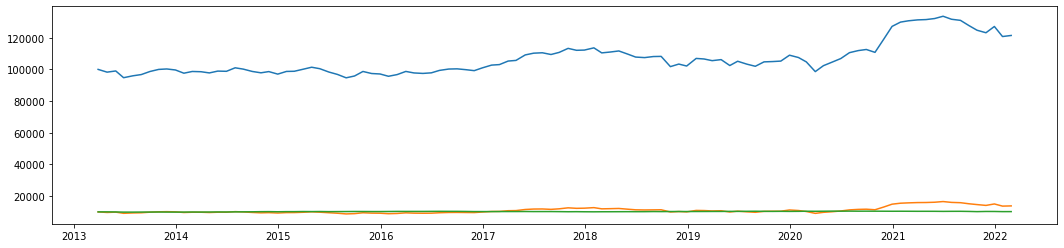

In [77]:
plt.figure(figsize=(18, 4))
plt.plot(back_test.date, back_test.backtest)
plt.plot(back_test.date, back_test.kodex_200)
plt.plot(back_test.date, back_test.gov_3Y)

plt.show()